# Deep Learning Models Training with Multiple Runs

This notebook trains MLP, LSTM, and GRU models for glucose prediction using multiple runs and saves only the best performing model.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set

Mounted at /content/drive
/content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set


In [ ]:
import os
import sys
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    mean_absolute_percentage_error,
)

# Add training directory to path
sys.path.append("/content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set/training")

from split_data import load_splits, rescale_data, print_results
from utils_dnn import (
    create_model,
    prepare_data,
    train_model,
    predict_in_batches,
    print_model_summary,
)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuration


In [ ]:
# Training configuration
MODELS = ["mlp", "lstm", "gru"]
BATCH_SIZE = 4096
EPOCHS = 100
LEARNING_RATE = 0.01
SEED = 42
N_RUNS = 3  # Number of training runs per model
OUTPUT_PATH = "outputs"

# Create output directory
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"Training configuration:")
print(f"Models: {MODELS}")
print(f"Runs per model: {N_RUNS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Random seed base: {SEED}")

Training configuration:
Models: ['mlp', 'lstm', 'gru']
Runs per model: 3
Batch size: 4096
Epochs: 100
Learning rate: 0.01
Random seed base: 42


## Load Data


In [ ]:
# Load pre-prepared data splits
print("Loading pre-prepared data splits...")
train_set, val_set, test_set, X_cols, y_cols = load_splits()

print(f"\nDataset sizes:")
print(f"Train set: {len(train_set)} samples")
print(f"Validation set: {len(val_set)} samples")
print(f"Test set: {len(test_set)} samples")
print(f"\nFeatures: {len(X_cols)} columns")
print(f"Targets: {len(y_cols)} columns")
print(f"\nX columns: {X_cols}")
print(f"y columns: {y_cols}")

Loading pre-prepared data splits...

Dataset sizes:
Train set: 14058224 samples
Validation set: 1861178 samples
Test set: 3945594 samples

Features: 8 columns
Targets: 1 columns

X columns: ['lag105', 'lag90', 'lag75', 'lag60', 'lag45', 'lag30', 'lag15', 'lag0']
y columns: ['lead30']


## Utility Functions


In [ ]:
def calculate_patient_based_mae(results_df):
    """Calculate patient-based MAE (same logic as used in evaluation)"""
    patient_maes = []
    for patient_id in results_df["Patient_ID"].unique():
        patient_data = results_df[results_df["Patient_ID"] == patient_id]
        mae = mean_absolute_error(patient_data["target"], patient_data["y_pred"])
        patient_maes.append(mae)
    return np.mean(patient_maes)


def train_single_run(
    model_name,
    run_id,
    train_set,
    val_set,
    X_cols,
    y_cols,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    seed_base=SEED,
):
    """
    Train a single model run
    """
    print(f"  Run {run_id + 1}/{N_RUNS}")
    print(f"  {'='*40}")

    # Set unique seed for this run
    run_seed = seed_base + run_id * 1000
    tf.keras.utils.set_random_seed(run_seed)
    print(f"  Using seed: {run_seed}")

    # Prepare data for TensorFlow
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
        train_set, val_set, test_set, X_cols, y_cols, model_name
    )

    # Create model
    model = create_model(model_name)
    if run_id == 0:  # Print model summary only for first run
        print_model_summary(model)

    # Train model with temporary weights file
    model, history = train_model(
        model,
        X_train,
        y_train,
        X_val,
        y_val,
        epochs=epochs,
        batch_size=batch_size,
        initial_learning_rate=lr,
        output_path=OUTPUT_PATH,
        exp_name=f"{model_name}_run_{run_id}",
    )

    # Evaluate on validation set
    val_set_run = val_set.copy()
    val_set_run["y_pred"] = predict_in_batches(
        model, val_set_run[X_cols], model_name, batch_size
    ).flatten()

    # Prepare results
    val_set_run = val_set_run.rename(columns={y_cols[-1]: "target"})
    val_set_run = rescale_data(val_set_run, ["target", "y_pred"])

    # Select output columns
    output_columns = ["Timestamp", "Patient_ID", "bgClass", "target", "y_pred"]
    results = val_set_run[output_columns]

    # Calculate patient-based MAE for this run
    patient_mae = calculate_patient_based_mae(results)

    print(f"  Run {run_id + 1} patient-based MAE: {patient_mae:.4f}")

    return {
        "model": model,
        "history": history,
        "results": results,
        "patient_mae": patient_mae,
        "weights_path": f"{OUTPUT_PATH}/{model_name}_run_{run_id}.weights.h5",
        "run_id": run_id,
        "seed": run_seed,
    }


def train_deep_model_multiple_runs(
    model_name, train_set, val_set, X_cols, y_cols, n_runs=N_RUNS
):
    """
    Train a deep learning model multiple times and keep the best one
    """
    print(f"\n{'='*60}")
    print(f"TRAINING {model_name.upper()} MODEL - {n_runs} RUNS")
    print(f"{'='*60}")

    runs_results = []

    # Train multiple runs
    for run_id in range(n_runs):
        run_result = train_single_run(
            model_name, run_id, train_set, val_set, X_cols, y_cols
        )
        runs_results.append(run_result)

    # Find best run based on patient-based MAE
    best_run = min(runs_results, key=lambda x: x["patient_mae"])

    print(f"\n{'='*60}")
    print(f"RUNS COMPARISON - {model_name.upper()}")
    print(f"{'='*60}")

    for run_result in runs_results:
        status = "🏆 BEST" if run_result == best_run else ""
        print(
            f"Run {run_result['run_id'] + 1} (seed {run_result['seed']}): "
            f"MAE = {run_result['patient_mae']:.4f} {status}"
        )

    print(
        f"\nBest run: Run {best_run['run_id'] + 1} with MAE = {best_run['patient_mae']:.4f}"
    )

    # Save best model weights with final name
    final_weights_path = f"{OUTPUT_PATH}/{model_name}.weights.h5"
    if os.path.exists(best_run["weights_path"]):
        if os.path.exists(final_weights_path):
            os.remove(final_weights_path)
        os.rename(best_run["weights_path"], final_weights_path)
        print(f"Best model weights saved as: {final_weights_path}")

    # Clean up temporary weight files from other runs
    for run_result in runs_results:
        if run_result != best_run and os.path.exists(run_result["weights_path"]):
            os.remove(run_result["weights_path"])
            print(f"Removed temporary weights: {run_result['weights_path']}")

    # Print detailed evaluation for best run
    print(f"\nDetailed evaluation for best run:")
    print_results(best_run["results"])

    # Save best results
    output_file = f"{OUTPUT_PATH}/{model_name}_output.csv"
    best_run["results"].to_csv(output_file, index=False)
    print(f"\nBest results saved to: {output_file}")

    return best_run

## Train All Models


In [ ]:
# Store results for comparison
training_results = {}
best_runs_info = {}

# Train each model with multiple runs
for model_name in MODELS:
    try:
        best_run = train_deep_model_multiple_runs(
            model_name, train_set, val_set, X_cols, y_cols
        )

        training_results[model_name] = best_run["results"]
        best_runs_info[model_name] = {
            "best_mae": best_run["patient_mae"],
            "best_run_id": best_run["run_id"] + 1,
            "best_seed": best_run["seed"],
            "history": best_run["history"],
        }

        print(f"\n✅ {model_name.upper()} training completed successfully!")
        print(
            f"Best performance: MAE = {best_run['patient_mae']:.4f} from run {best_run['run_id'] + 1}"
        )

    except Exception as e:
        print(f"\n❌ Error training {model_name.upper()}: {str(e)}")
        continue

print(f"\n{'='*80}")
print("ALL TRAINING COMPLETED")
print(f"{'='*80}")
print(f"Successfully trained models: {list(training_results.keys())}")


TRAINING MLP MODEL - 3 RUNS
  Run 1/3
  Using seed: 42

Model Architecture:


Model: "MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,353 (267.00 KB)

 Trainable params: 68,353 (267.00 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 68,353
Epoch 1/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - mae: 0.0957  
Epoch 1: val_loss improved from inf to 0.00608, saving model to outputs/mlp_run_0.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0141 - mae: 0.0954 - val_loss: 0.0061 - val_mae: 0.0783 - learning_rate: 0.0100
Epoch 2/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.0063 - mae: 0.0805
Epoch 2: val_loss improved from 0.00608 to 0.00598, saving model to outputs/mlp_run_0.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 4s 941us/step - loss: 0.0063 - mae: 0.0805 - val_loss: 0.0060 - val_mae: 0.0777 - learning_rate: 0.0100
Epoch 3/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0203 - mae: 0.1020
Epoch 3: val_loss did not improve from 0.00598
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 4s 926us/step - loss: 0.0205 - mae: 0.1024 - val_loss: 0.0061 - val_mae: 0.0786 - learning_rate: 0.0100
Epoch 4/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.0084 - m

  Run 3 patient-based MAE: 13.8807

RUNS COMPARISON - MLP
Run 1 (seed 42): MAE = 13.7311 🏆 BEST
Run 2 (seed 1042): MAE = 13.7355 
Run 3 (seed 2042): MAE = 13.8807 

Best run: Run 1 with MAE = 13.7311
Best model weights saved as: outputs/mlp.weights.h5
Removed temporary weights: outputs/mlp_run_1.weights.h5
Removed temporary weights: outputs/mlp_run_2.weights.h5

Detailed evaluation for best run:
Cumulative
Samples: 1861178
MAE: 13.73(2.05)
MAPE: 9.61(1.65)
RMSE: 18.99(2.87)
~~~~~~~~~~
Normal
Samples: 1147765
MAE: 12.41(1.95)
MAPE: 10.13(1.68)
RMSE: 17.32(2.76)
~~~~~~~~~~
Hyper
Samples: 614538
MAE: 16.19(2.26)
MAPE: 7.07(0.91)
RMSE: 21.95(2.97)
~~~~~~~~~~
Hypo
Samples: 98875
MAE: 13.77(2.32)
MAPE: 23.29(4.14)
RMSE: 17.42(3.54)

Best results saved to: outputs/mlp_output.csv

✅ MLP training completed successfully!
Best performance: MAE = 13.7311 from run 1

TRAINING LSTM MODEL - 3 RUNS
  Run 1/3
  Using seed: 42

Model Architecture:


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8, 75)          │        23,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 75)             │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,476 (267.48 KB)

 Trainable params: 68,476 (267.48 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 68,476
Epoch 1/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0068 - mae: 0.0829
Epoch 1: val_loss improved from inf to 0.00584, saving model to outputs/lstm_run_0.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 68s 17ms/step - loss: 0.0068 - mae: 0.0828 - val_loss: 0.0058 - val_mae: 0.0778 - learning_rate: 0.0100
Epoch 2/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059 - mae: 0.0777
Epoch 2: val_loss improved from 0.00584 to 0.00577, saving model to outputs/lstm_run_0.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 64s 17ms/step - loss: 0.0059 - mae: 0.0777 - val_loss: 0.0058 - val_mae: 0.0771 - learning_rate: 0.0100
Epoch 3/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059 - mae: 0.0774
Epoch 3: val_loss improved from 0.00577 to 0.00567, saving model to outputs/lstm_run_0.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 64s 17ms/step - loss: 0.0059 - mae: 0.0774 - val_loss: 0.0057 - val_mae: 0.0758 - learning_rate: 0.0100
Epoch 4/100
3329/3433 ━━

Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8, 86)          │        22,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 86)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 86)             │        44,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            87 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,941 (265.39 KB)

 Trainable params: 67,941 (265.39 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 67,941
Epoch 1/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0066 - mae: 0.0816
Epoch 1: val_loss improved from inf to 0.00580, saving model to outputs/gru_run_0.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 69s 18ms/step - loss: 0.0066 - mae: 0.0815 - val_loss: 0.0058 - val_mae: 0.0774 - learning_rate: 0.0100
Epoch 2/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059 - mae: 0.0778
Epoch 2: val_loss did not improve from 0.00580
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - loss: 0.0059 - mae: 0.0778 - val_loss: 0.0058 - val_mae: 0.0773 - learning_rate: 0.0100
Epoch 3/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059 - mae: 0.0776
Epoch 3: val_loss did not improve from 0.00580
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - loss: 0.0059 - mae: 0.0776 - val_loss: 0.0058 - val_mae: 0.0772 - learning_rate: 0.0100
Epoch 4/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059 - mae: 0.0775
Epoch 4: ReduceLROnPlateau reducing learni

## Training Summary


In [ ]:
# Display detailed training summary
if best_runs_info:
    print(f"\n{'='*80}")
    print("DETAILED TRAINING SUMMARY")
    print(f"{'='*80}")

    for model_name, info in best_runs_info.items():
        print(f"\n{model_name.upper()}:")
        print(f"  Best Run: {info['best_run_id']}/{N_RUNS}")
        print(f"  Best Seed: {info['best_seed']}")
        print(f"  Best Patient-based MAE: {info['best_mae']:.4f}")
        print(f"  Weights saved: {OUTPUT_PATH}/{model_name}.weights.h5")
        print(f"  Results saved: {OUTPUT_PATH}/{model_name}_output.csv")


DETAILED TRAINING SUMMARY

MLP:
  Best Run: 1/3
  Best Seed: 42
  Best Patient-based MAE: 13.7311
  Weights saved: outputs/mlp.weights.h5
  Results saved: outputs/mlp_output.csv

LSTM:
  Best Run: 2/3
  Best Seed: 1042
  Best Patient-based MAE: 13.5510
  Weights saved: outputs/lstm.weights.h5
  Results saved: outputs/lstm_output.csv

GRU:
  Best Run: 1/3
  Best Seed: 42
  Best Patient-based MAE: 13.5439
  Weights saved: outputs/gru.weights.h5
  Results saved: outputs/gru_output.csv


## Visualize Best Training Histories


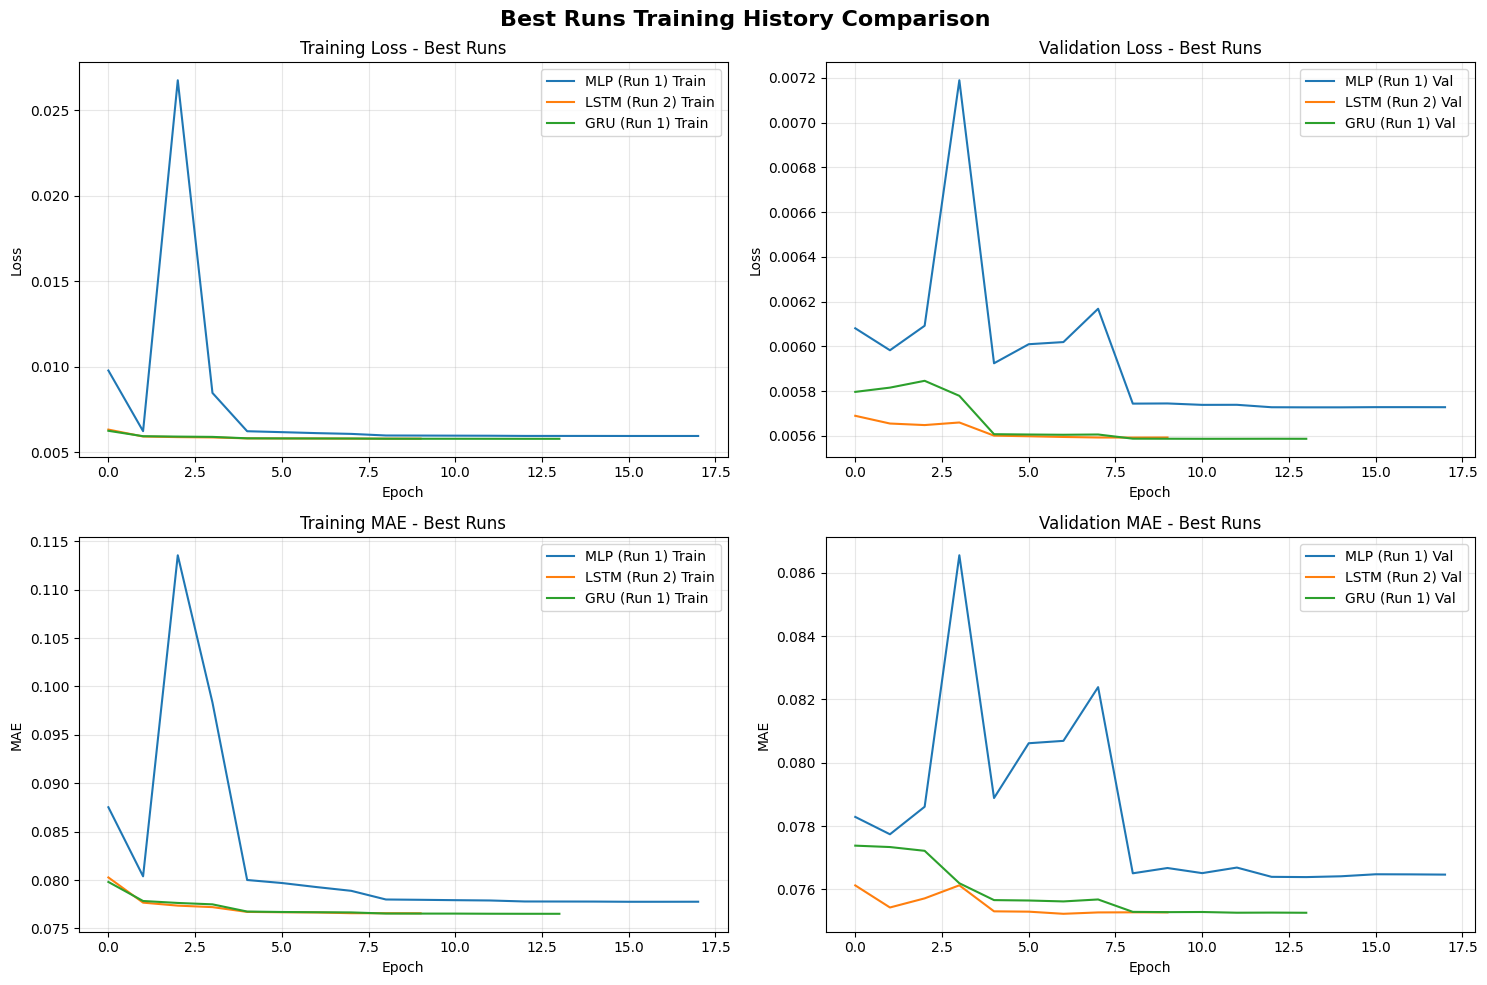

Best runs training history plot saved to outputs/best_runs_training_history.png


In [ ]:
# Plot training histories of best runs
if best_runs_info:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(
        "Best Runs Training History Comparison", fontsize=16, fontweight="bold"
    )

    # Loss plots
    for model_name, info in best_runs_info.items():
        history = info["history"]
        run_id = info["best_run_id"]
        axes[0, 0].plot(
            history.history["loss"], label=f"{model_name.upper()} (Run {run_id}) Train"
        )
        axes[0, 1].plot(
            history.history["val_loss"],
            label=f"{model_name.upper()} (Run {run_id}) Val",
        )

    axes[0, 0].set_title("Training Loss - Best Runs")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_title("Validation Loss - Best Runs")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # MAE plots
    for model_name, info in best_runs_info.items():
        history = info["history"]
        run_id = info["best_run_id"]
        axes[1, 0].plot(
            history.history["mae"], label=f"{model_name.upper()} (Run {run_id}) Train"
        )
        axes[1, 1].plot(
            history.history["val_mae"], label=f"{model_name.upper()} (Run {run_id}) Val"
        )

    axes[1, 0].set_title("Training MAE - Best Runs")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("MAE")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_title("Validation MAE - Best Runs")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("MAE")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        f"{OUTPUT_PATH}/best_runs_training_history.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print(
        f"Best runs training history plot saved to {OUTPUT_PATH}/best_runs_training_history.png"
    )

## Results Summary


In [ ]:
# Calculate summary metrics for each best model
if training_results:
    summary_data = []

    for model_name, results in training_results.items():
        mae = mean_absolute_error(results["target"], results["y_pred"])
        rmse = root_mean_squared_error(results["target"], results["y_pred"])
        mape = (
            mean_absolute_percentage_error(results["target"], results["y_pred"]) * 100
        )
        patient_mae = best_runs_info[model_name]["best_mae"]
        best_run = best_runs_info[model_name]["best_run_id"]
        best_seed = best_runs_info[model_name]["best_seed"]

        summary_data.append(
            {
                "Model": model_name.upper(),
                "Best Run": f"{best_run}/{N_RUNS}",
                "Best Seed": best_seed,
                "Patient MAE": f"{patient_mae:.4f}",
                "Overall MAE": f"{mae:.2f}",
                "RMSE": f"{rmse:.2f}",
                "MAPE (%)": f"{mape:.2f}",
                "Samples": len(results),
            }
        )

    summary_df = pd.DataFrame(summary_data)

    print("\n" + "=" * 100)
    print("BEST MODELS PERFORMANCE SUMMARY")
    print("=" * 100)
    print(summary_df.to_string(index=False))

    # Save summary
    summary_df.to_csv(f"{OUTPUT_PATH}/dnn_best_models_summary.csv", index=False)
    print(f"\nSummary saved to {OUTPUT_PATH}/dnn_best_models_summary.csv")


BEST MODELS PERFORMANCE SUMMARY
Model Best Run  Best Seed Patient MAE Overall MAE  RMSE MAPE (%)  Samples
  MLP      1/3         42     13.7311       13.75 19.26     9.89  1861178
 LSTM      2/3       1042     13.5510       13.55 19.04     9.70  1861178
  GRU      1/3         42     13.5439       13.55 19.03     9.74  1861178

Summary saved to outputs/dnn_best_models_summary.csv


## Model Comparison Visualization


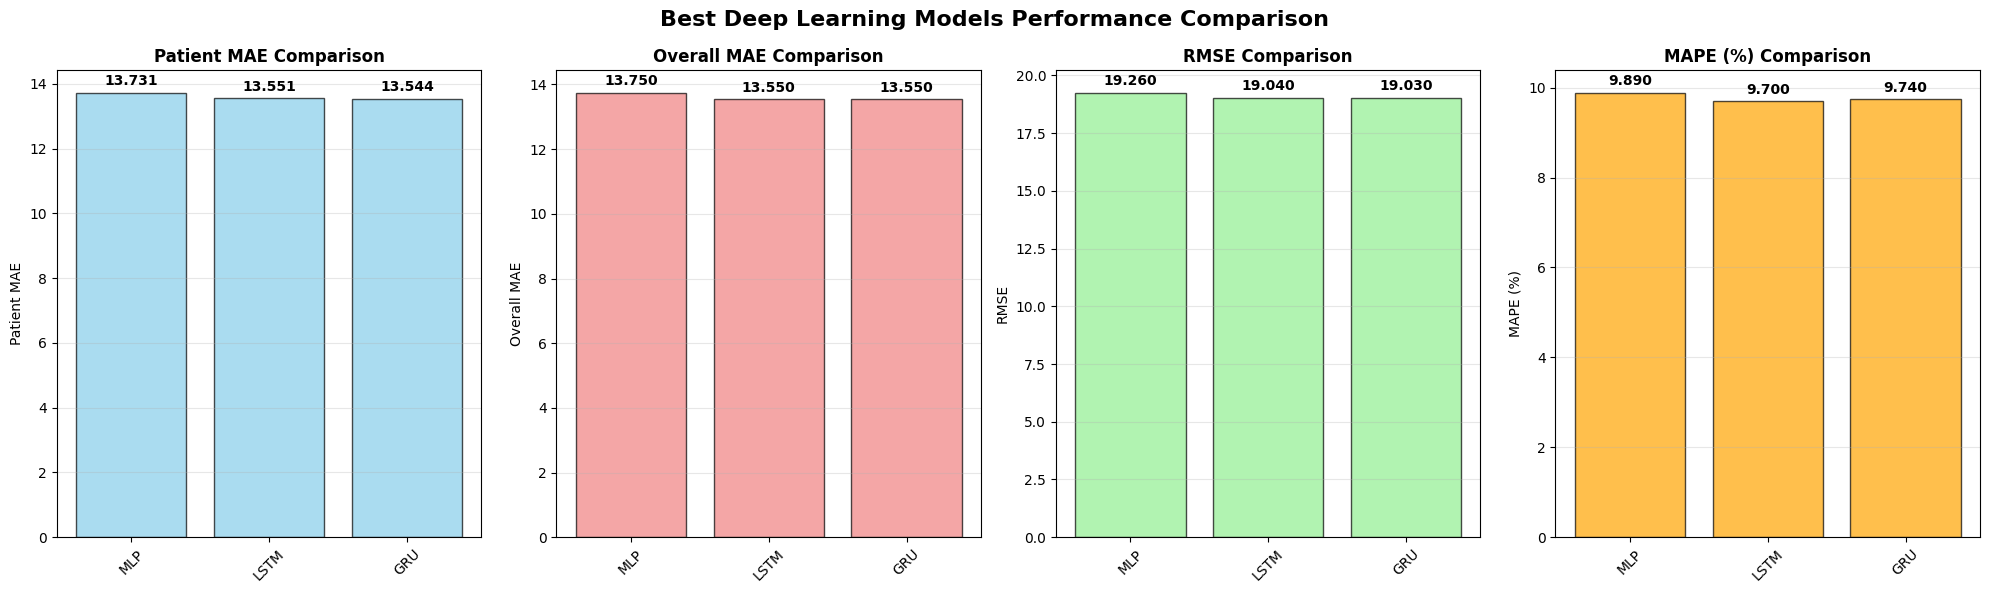

Best models comparison plot saved to outputs/dnn_best_models_comparison.png


In [ ]:
# Create comparison plots for best models
if len(training_results) > 1:
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(
        "Best Deep Learning Models Performance Comparison",
        fontsize=16,
        fontweight="bold",
    )

    metrics = ["Patient MAE", "Overall MAE", "RMSE", "MAPE (%)"]
    colors = ["skyblue", "lightcoral", "lightgreen", "orange"]

    for i, metric in enumerate(metrics):
        values = [float(row[metric]) for row in summary_data]
        models = [row["Model"] for row in summary_data]

        bars = axes[i].bar(
            models, values, color=colors[i], alpha=0.7, edgecolor="black"
        )
        axes[i].set_title(f"{metric} Comparison", fontweight="bold")
        axes[i].set_ylabel(metric)
        axes[i].grid(True, alpha=0.3, axis="y")

        # Add value labels on bars
        for bar, value in zip(bars, values):
            axes[i].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + max(values) * 0.01,
                f"{value:.3f}",
                ha="center",
                va="bottom",
                fontweight="bold",
            )

        # Rotate x-axis labels if needed
        axes[i].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.savefig(
        f"{OUTPUT_PATH}/dnn_best_models_comparison.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print(
        f"Best models comparison plot saved to {OUTPUT_PATH}/dnn_best_models_comparison.png"
    )

## Final Summary


In [ ]:
print("\n" + "=" * 100)
print("DEEP LEARNING TRAINING PIPELINE WITH MULTIPLE RUNS COMPLETED")
print("=" * 100)
print(f"\n📁 Output directory: {OUTPUT_PATH}")
print(f"🎯 Models trained: {len(training_results)}")
print(f"🔄 Runs per model: {N_RUNS}")
print(f"📊 Results files generated:")

# List all generated files
output_files = [f"{model_name}_output.csv" for model_name in training_results.keys()]
output_files.extend(
    [f"{model_name}.weights.h5" for model_name in training_results.keys()]
)
output_files.extend(
    [
        "dnn_best_models_summary.csv",
        "best_runs_training_history.png",
        "dnn_best_models_comparison.png",
    ]
)

for file in output_files:
    if os.path.exists(f"{OUTPUT_PATH}/{file}"):
        print(f"   ✅ {file}")
    else:
        print(f"   ❌ {file} (not found)")

if training_results and summary_data:
    best_model = min(summary_data, key=lambda x: float(x["Patient MAE"]))
    print(f"\n🏆 Best performing model: {best_model['Model']} ")
    print(f"   Patient-based MAE: {best_model['Patient MAE']}")
    print(f"   From run: {best_model['Best Run']}")
    print(f"   Using seed: {best_model['Best Seed']}")

print("\n" + "=" * 100)
print("🎉 All models trained successfully with multiple runs!")
print("Only the best performing run for each model has been saved.")
print("=" * 100)


DEEP LEARNING TRAINING PIPELINE WITH MULTIPLE RUNS COMPLETED

📁 Output directory: outputs
🎯 Models trained: 3
🔄 Runs per model: 3
📊 Results files generated:
   ✅ mlp_output.csv
   ✅ lstm_output.csv
   ✅ gru_output.csv
   ✅ mlp.weights.h5
   ✅ lstm.weights.h5
   ✅ gru.weights.h5
   ✅ dnn_best_models_summary.csv
   ✅ best_runs_training_history.png
   ✅ dnn_best_models_comparison.png

🏆 Best performing model: GRU 
   Patient-based MAE: 13.5439
   From run: 1/3
   Using seed: 42

🎉 All models trained successfully with multiple runs!
Only the best performing run for each model has been saved.


In [ ]:
from google.colab import runtime
runtime.unassign()